# Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset, ConcatDataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

!pip install optuna
import optuna

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 30.2 MB/s eta 0:00:00
Mounted at /content/drive


# Global Variables

In [3]:
# --- Dataset variables ---
BATCH_SIZE = 64
NUM_WORKERS = 4
#ROOT = '/content/drive/My Drive/Colab Notebooks/156 Project/Rice_Image_Dataset'
ROOT = '/content/drive/My Drive/156 Project/Rice_Image_Dataset' #this is the root for Farrel


FULL_DATASET = ImageFolder(root=ROOT)
NUM_CLASSES = len(FULL_DATASET.classes)

# --- DEVICE ---
DEVICE = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
print("Using device:", DEVICE)


# --- Train and Validation Set Proportions ---
P_TRAIN = 0.6 #0.6
P_VAL = 0.2 #0.2
P_TUNE = 0.3

# --- Training Parameters ---
CRITERION = nn.CrossEntropyLoss()
LEARNING_RATE = 0.001
NUM_EPOCHS = 20 #20
HIDDEN_SIZE = 32
OPTIMIZER = optim.Adam

# --- Validation Parameters ---
NUM_TRIALS = 20

Using device: cuda


# Exploratory Data Analysis

In this dataset, each of the five classes contributes exactly 15,000 images, so class representation is perfectly balanced across the full distribution. Furthermore, image sizing is consistent where each image is 250x250 pixels.

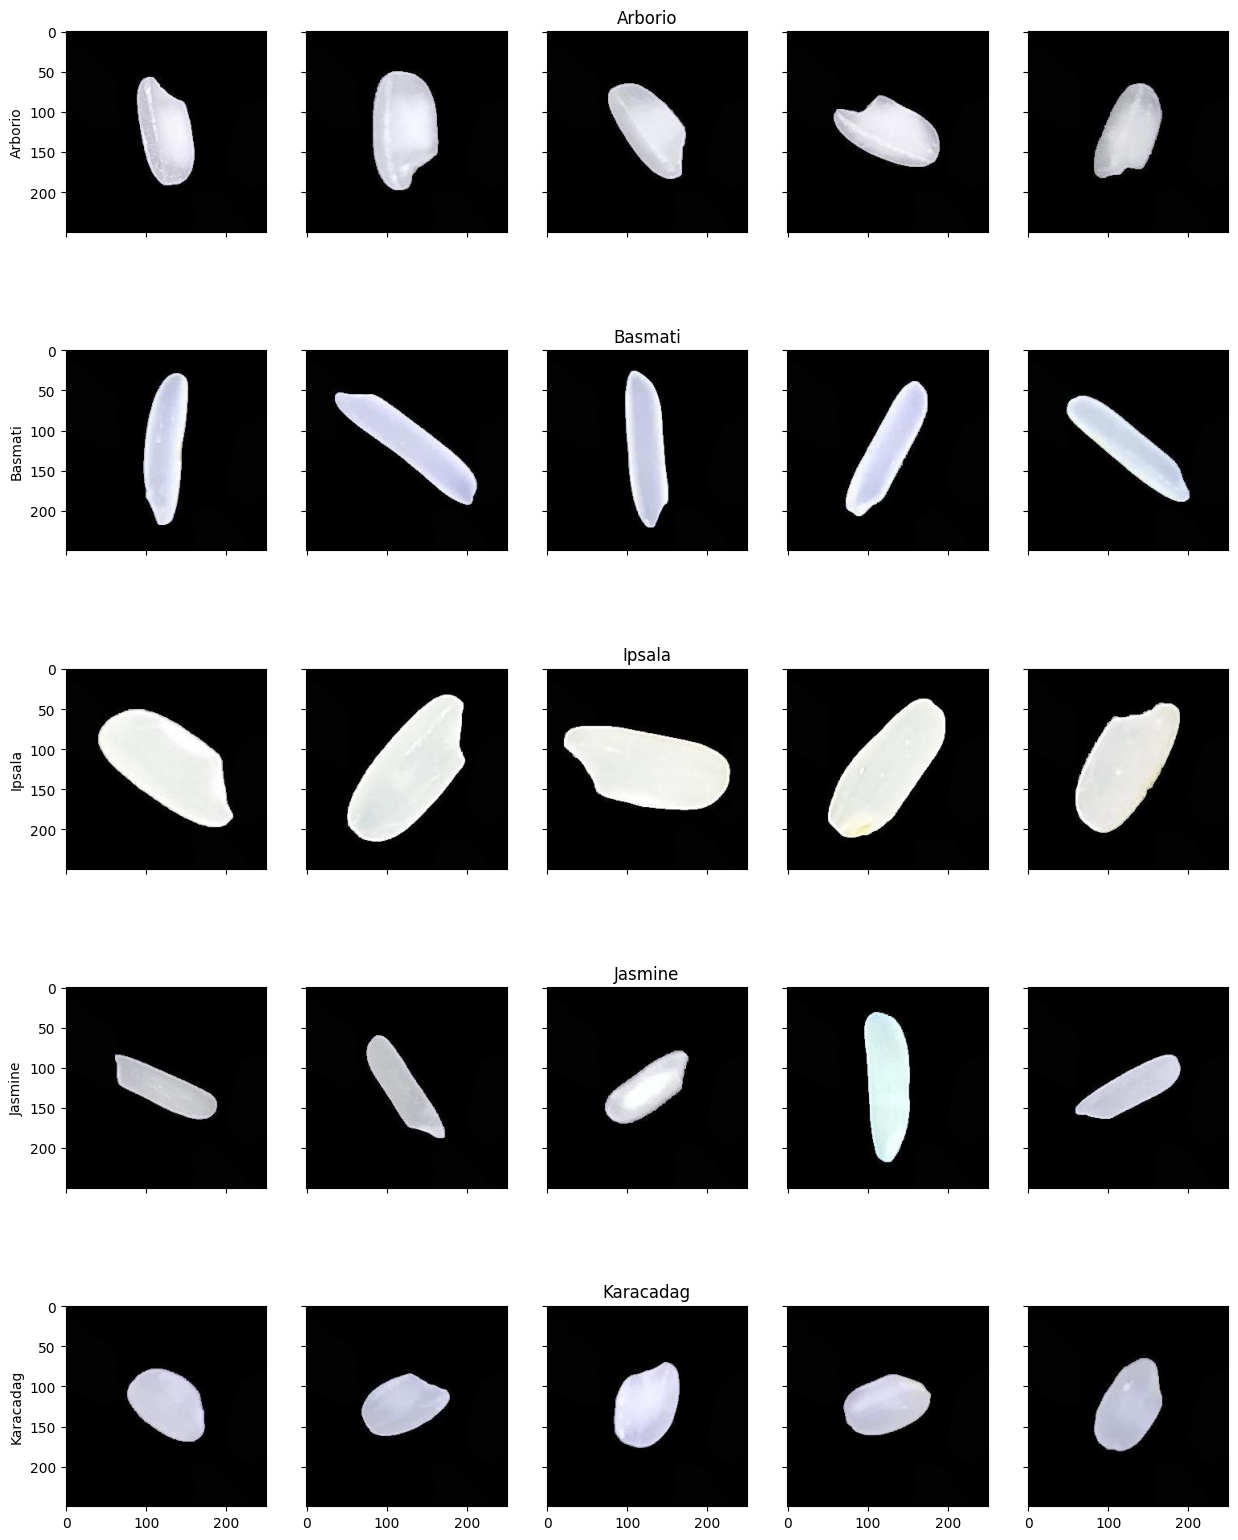

In [4]:
idx = [np.arange(5)* 15000] * 5 + np.random.choice(15000,(5,5))
idx = idx.T

fig, ax = plt.subplots(5,5, figsize=(15,20),sharex=True,sharey=True)

for r, l in enumerate(idx):
    for c, i in enumerate(l):
        im,lbl = FULL_DATASET[i]

        ax[r,c].imshow(im)
        if c == 0:
            ax[r,c].set_ylabel(f'{FULL_DATASET.classes[lbl]}')
        if c == 2:
            ax[r,c].set_title(f'{FULL_DATASET.classes[lbl]}')

# Preprocessing

We compute the mean and standard deviation over the entire dataset and use these values to normalize the inputs. Since mean and standard deviation are low-level, label-agnostic statistics (they do not encode target information directly), estimating them on the full dataset does not introduce any meaningful form of data leakage in this context. Practically, using the full dataset also avoids the extra overhead of recomputing these statistics on the training subset only, while still providing stable, representative normalization parameters.

In [5]:
'''
pre_transform = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor()
])

pre_dataset = ImageFolder(root=ROOT, transform=pre_transform)
pre_loader = DataLoader(pre_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

mean = 0.0
std = 0.0
nb_samples = 0.0

for d, _ in pre_loader:
    batch_samples = d.size(0)
    d = d.view(batch_samples, d.size(1), -1)
    mean += d.mean(2).sum(0)
    std += d.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print(f"mean:{mean}")
print(f'std: {std}')
'''

mean = [0.1179, 0.1189, 0.1229]
std = [0.2851, 0.2875, 0.2989]

## Transforms

In [6]:
train_transform = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_test_transform = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
])

## Train, Validation, and Test Set Division

In [7]:
total_size = len(FULL_DATASET)
train_size = int(P_TRAIN * total_size)
val_size = int(P_VAL * total_size)
test_size = total_size - train_size - val_size

train_sub, val_sub, test_sub = random_split(
    FULL_DATASET, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_idx = train_sub.indices
val_idx   = val_sub.indices
test_idx  = test_sub.indices

train_set = Subset(ImageFolder(ROOT, transform=train_transform), train_idx)
val_set   = Subset(ImageFolder(ROOT, transform=val_test_transform), val_idx)
test_set  = Subset(ImageFolder(ROOT, transform=val_test_transform), test_idx)

train_loader = DataLoader(train_set, BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader = DataLoader(val_set,     BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_set,   BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Gathering data for PCA...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


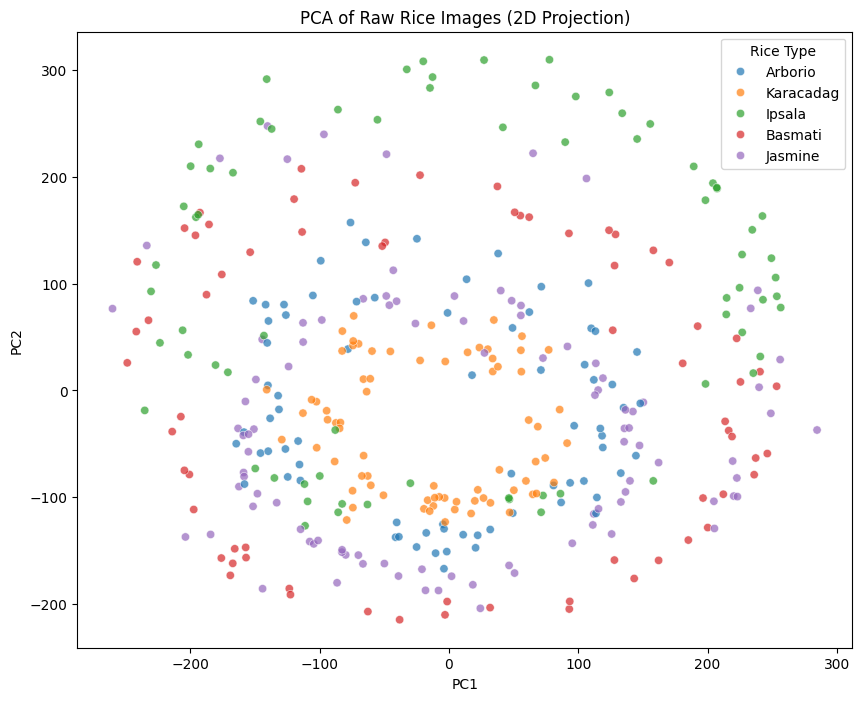

In [8]:
from sklearn.decomposition import PCA
import pandas as pd
import seaborn as sns

images_flat = []
labels_list = []

print("Gathering data for PCA...")
for i, (imgs, lbls) in enumerate(val_loader):
    if i > 5: break
    flat = imgs.view(imgs.size(0), -1).numpy()
    images_flat.extend(flat)
    labels_list.extend(lbls.numpy())

pca = PCA(n_components=2)
pca_result = pca.fit_transform(images_flat)

plt.figure(figsize=(10, 8))
df_pca = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
df_pca['Rice Type'] = [FULL_DATASET.classes[l] for l in labels_list]

sns.scatterplot(x='PC1', y='PC2', hue='Rice Type', data=df_pca, palette='tab10', alpha=0.7)
plt.title('PCA of Raw Rice Images (2D Projection)')
plt.show()

# Creating the CNN

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes, hidden_size):
        super(CNN,self).__init__()
        hidden_size2 = hidden_size*2
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3,  out_channels=hidden_size, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2),

            nn.Conv2d(in_channels=hidden_size, out_channels=hidden_size2, kernel_size= 5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(hidden_size2,num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        out = self.classifier(x)
        return out

## Summary

In [10]:
cnn = CNN(NUM_CLASSES,HIDDEN_SIZE)
cnn = cnn.to(DEVICE)
summary(cnn,(3,250,250))
optimizer = OPTIMIZER(cnn.parameters(),lr=LEARNING_RATE)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 246, 246]           2,432
              ReLU-2         [-1, 32, 246, 246]               0
         MaxPool2d-3         [-1, 32, 123, 123]               0
            Conv2d-4         [-1, 64, 119, 119]          51,264
              ReLU-5         [-1, 64, 119, 119]               0
         MaxPool2d-6           [-1, 64, 59, 59]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
           Flatten-8                   [-1, 64]               0
            Linear-9                    [-1, 5]             325
Total params: 54,021
Trainable params: 54,021
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.72
Forward/backward pass size (MB): 48.77
Params size (MB): 0.21
Estimated Total Size (MB): 49.69
-------------------------------------------

## Evaluate Function

In [14]:
# TODO: Add more metrics, maybe specifically just for test set, so create a new function?
def evaluate(model, loader, device, leave=True):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Evaluation: ', leave=leave):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = CRITERION(outputs, labels)
            total_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs,1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy

# Training the CNN

In [29]:
train_loss_list = []
val_loss_list = []
val_accuracy_list = []

cnn = cnn.to(DEVICE)

for epoch in range(NUM_EPOCHS):
    cnn.train()
    running_loss = 0.0

    loop = tqdm(train_loader, desc=f'Epoch [{epoch+1}/{NUM_EPOCHS}]', leave=True)

    for images, labels in loop:
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = cnn(images)
        loss = CRITERION(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

        loop.set_postfix(batch_loss=loss.item())

    train_loss = running_loss / len(train_loader.dataset)
    val_loss, val_acc = evaluate(cnn, val_loader, DEVICE)

    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    val_accuracy_list.append(val_acc)

    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}]: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}' )


Epoch [1/20]:   0%|          | 0/705 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [1/20]: Train Loss: 0.2678 | Val Loss: 0.4059 | Val Acc: 0.8170


Epoch [2/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [2/20]: Train Loss: 0.2573 | Val Loss: 0.1638 | Val Acc: 0.9378


Epoch [3/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [3/20]: Train Loss: 0.2396 | Val Loss: 0.1423 | Val Acc: 0.9503


Epoch [4/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [4/20]: Train Loss: 0.2255 | Val Loss: 0.1969 | Val Acc: 0.9231


Epoch [5/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [5/20]: Train Loss: 0.2166 | Val Loss: 0.0901 | Val Acc: 0.9746


Epoch [6/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [6/20]: Train Loss: 0.1958 | Val Loss: 0.0941 | Val Acc: 0.9795


Epoch [7/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [7/20]: Train Loss: 0.1873 | Val Loss: 0.1325 | Val Acc: 0.9497


Epoch [8/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [8/20]: Train Loss: 0.1752 | Val Loss: 0.1939 | Val Acc: 0.9334


Epoch [9/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [9/20]: Train Loss: 0.1631 | Val Loss: 0.0527 | Val Acc: 0.9860


Epoch [10/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [10/20]: Train Loss: 0.1517 | Val Loss: 0.0917 | Val Acc: 0.9691


Epoch [11/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [11/20]: Train Loss: 0.1550 | Val Loss: 0.0432 | Val Acc: 0.9880


Epoch [12/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [12/20]: Train Loss: 0.1347 | Val Loss: 0.0497 | Val Acc: 0.9860


Epoch [13/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [13/20]: Train Loss: 0.1353 | Val Loss: 0.0899 | Val Acc: 0.9726


Epoch [14/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [14/20]: Train Loss: 0.1287 | Val Loss: 0.0448 | Val Acc: 0.9910


Epoch [15/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [15/20]: Train Loss: 0.1206 | Val Loss: 0.0713 | Val Acc: 0.9829


Epoch [16/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [16/20]: Train Loss: 0.1212 | Val Loss: 0.1269 | Val Acc: 0.9637


Epoch [17/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [17/20]: Train Loss: 0.1113 | Val Loss: 0.0615 | Val Acc: 0.9902


Epoch [18/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [18/20]: Train Loss: 0.1220 | Val Loss: 0.0663 | Val Acc: 0.9876


Epoch [19/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [19/20]: Train Loss: 0.1076 | Val Loss: 0.0371 | Val Acc: 0.9905


Epoch [20/20]:   0%|          | 0/705 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch [20/20]: Train Loss: 0.1004 | Val Loss: 0.0616 | Val Acc: 0.9847


In [30]:
drive_path = '/content/drive/My Drive/156 Project/rice_cnn_best_model.pth'
torch.save(final_model.state_dict(), drive_path)
print(f"Model saved permanently to {drive_path}")

Model saved permanently to /content/drive/My Drive/156 Project/rice_cnn_best_model.pth


In [31]:
from google.colab import files
files.download('rice_cnn_best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:

loaded_model = CNN(num_classes=NUM_CLASSES, hidden_size=32)
loaded_model = loaded_model.to(DEVICE)


load_path = '/content/drive/My Drive/156 Project/rice_cnn_best_model.pth'


loaded_model.load_state_dict(torch.load(load_path, map_location=DEVICE))

loaded_model.eval()

print("Model loaded successfully!")

Model loaded successfully!


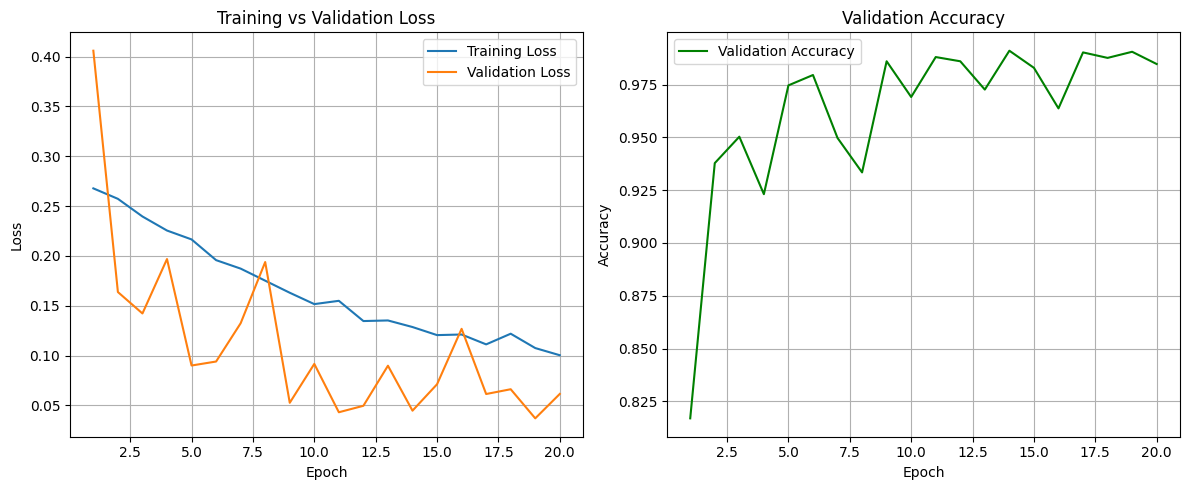

In [16]:
import matplotlib.pyplot as plt
import numpy as np

train_loss_list = [
    0.2678, 0.2573, 0.2396, 0.2255, 0.2166,
    0.1958, 0.1873, 0.1752, 0.1631, 0.1517,
    0.1550, 0.1347, 0.1353, 0.1287, 0.1206,
    0.1212, 0.1113, 0.1220, 0.1076, 0.1004
]

val_loss_list = [
    0.4059, 0.1638, 0.1423, 0.1969, 0.0901,
    0.0941, 0.1325, 0.1939, 0.0527, 0.0917,
    0.0432, 0.0497, 0.0899, 0.0448, 0.0713,
    0.1269, 0.0615, 0.0663, 0.0371, 0.0616
]

val_accuracy_list = [
    0.8170, 0.9378, 0.9503, 0.9231, 0.9746,
    0.9795, 0.9497, 0.9334, 0.9860, 0.9691,
    0.9880, 0.9860, 0.9726, 0.9910, 0.9829,
    0.9637, 0.9902, 0.9876, 0.9905, 0.9847
]


NUM_EPOCHS = 20
fig, ax = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

# Plot Losses
ax[0].plot(range(1, NUM_EPOCHS + 1), train_loss_list, label="Training Loss")
ax[0].plot(range(1, NUM_EPOCHS + 1), val_loss_list, label="Validation Loss")
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Training vs Validation Loss')
ax[0].legend()
ax[0].grid(True)

# Plot Accuracy
ax[1].plot(range(1, NUM_EPOCHS + 1), val_accuracy_list, label="Validation Accuracy", color='green')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Validation Accuracy')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()

## Visuals

NameError: name 'train_loss_list' is not defined

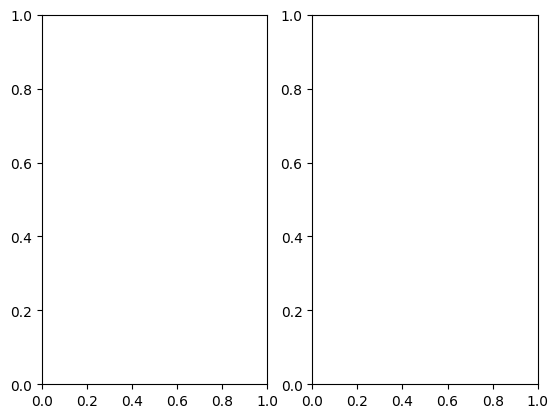

In [12]:
fig, ax = plt.subplots(1,2, sharex=True)
ax[0].plot(range(NUM_EPOCHS), train_loss_list,   label = "Training Loss")
ax[0].plot(range(NUM_EPOCHS), val_loss_list,     label = 'Validation Loss')
ax[1].plot(range(NUM_EPOCHS), val_accuracy_list, label = 'Validation Accuracy')
ax[0].set_xlabel('Epoch')
ax[1].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss')
ax[1].set_title('Accuracy')
ax[0].legend()
ax[1].legend()
fig.tight_layout()

print(np.round(train_loss_list,3))
print(np.round(val_loss_list,3))
print(np.round(val_accuracy_list,3))

# Validation and Hyperparameter Tuning

In [16]:
indices = np.random.choice(len(train_set), int(len(train_set)*P_TUNE), replace=False) # tuning on subset of training dataset
tune_train_set = Subset(train_set, indices)
tune_train_loader = DataLoader(tune_train_set, BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [17]:
def objective(trial):

    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    hidden_size = trial.suggest_categorical('hidden_size', [16,32,64])
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)

    cnn = CNN(NUM_CLASSES, hidden_size)
    cnn = cnn.to(DEVICE)
    optimizer = OPTIMIZER(cnn.parameters(), lr=lr, weight_decay = weight_decay)

    for epoch in range(3):
        cnn.train()
        for images, labels in tune_train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = cnn(images)
            loss = CRITERION(outputs,labels)
            loss.backward()
            optimizer.step()
        val_loss, val_acc = evaluate(cnn, val_loader, DEVICE)
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.TrialPruned()

    val_loss, val_acc = evaluate(cnn, val_loader, DEVICE, leave=False)
    return val_loss

pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='minimize',pruner=pruner)
study.optimize(objective, n_trials=NUM_TRIALS, show_progress_bar=True)
print("Best trial:", study.best_trial.params)
best = study.best_trial.params

[I 2025-11-26 14:14:57,381] A new study created in memory with name: no-name-46388456-bfd1-470b-8555-6c7939068b6d


  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 14:23:29,088] Trial 0 finished with value: 0.7836271752435638 and parameters: {'lr': 0.004880558066041777, 'hidden_size': 32, 'weight_decay': 4.164829388000623e-05}. Best is trial 0 with value: 0.7836271752435638.


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 14:31:59,440] Trial 1 finished with value: 0.9972519736642027 and parameters: {'lr': 0.00026525153863716264, 'hidden_size': 32, 'weight_decay': 0.00015722387869145343}. Best is trial 0 with value: 0.7836271752435638.


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 14:40:27,105] Trial 2 finished with value: 0.6237540641864918 and parameters: {'lr': 0.007579601983496047, 'hidden_size': 16, 'weight_decay': 0.00011294537529007721}. Best is trial 2 with value: 0.6237540641864918.


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 14:49:00,242] Trial 3 finished with value: 1.0043106074101773 and parameters: {'lr': 0.00010021077455350188, 'hidden_size': 32, 'weight_decay': 1.8176511748663852e-06}. Best is trial 2 with value: 0.6237540641864918.


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 14:57:26,852] Trial 4 finished with value: 1.0066856799482164 and parameters: {'lr': 0.0002159863014398156, 'hidden_size': 16, 'weight_decay': 1.0713505530630346e-05}. Best is trial 2 with value: 0.6237540641864918.


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 15:05:52,545] Trial 5 finished with value: 0.8524255881288241 and parameters: {'lr': 0.0020755385216722506, 'hidden_size': 16, 'weight_decay': 5.505228111128701e-06}. Best is trial 2 with value: 0.6237540641864918.


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 15:14:59,265] Trial 6 finished with value: 0.7873329308250282 and parameters: {'lr': 0.00055231347889358, 'hidden_size': 64, 'weight_decay': 1.3154524994034739e-06}. Best is trial 2 with value: 0.6237540641864918.


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 15:17:27,671] Trial 7 pruned. 


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 15:25:25,168] Trial 8 pruned. 


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 15:34:23,425] Trial 9 finished with value: 0.7405155939003828 and parameters: {'lr': 0.0012281187772049309, 'hidden_size': 64, 'weight_decay': 7.882937352828025e-05}. Best is trial 2 with value: 0.6237540641864918.


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 15:36:49,792] Trial 10 pruned. 


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 15:45:52,351] Trial 11 finished with value: 1.423059584646693 and parameters: {'lr': 0.0017180069927877153, 'hidden_size': 64, 'weight_decay': 8.135934765555062e-05}. Best is trial 2 with value: 0.6237540641864918.


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 15:51:09,299] Trial 12 pruned. 


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 15:53:45,521] Trial 13 pruned. 


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 15:58:35,308] Trial 14 pruned. 


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 16:01:02,294] Trial 15 pruned. 


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 16:03:42,375] Trial 16 pruned. 


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 16:08:34,393] Trial 17 pruned. 


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 16:17:38,029] Trial 18 finished with value: 0.527397116660183 and parameters: {'lr': 0.0011688971023001234, 'hidden_size': 64, 'weight_decay': 0.0001050317305926172}. Best is trial 18 with value: 0.527397116660183.


Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

[I 2025-11-26 16:26:13,379] Trial 19 finished with value: 0.6536279613323642 and parameters: {'lr': 0.002800028541785778, 'hidden_size': 32, 'weight_decay': 0.0002867603005519822}. Best is trial 18 with value: 0.527397116660183.
Best trial: {'lr': 0.0011688971023001234, 'hidden_size': 64, 'weight_decay': 0.0001050317305926172}


# Testing the CNN

## Retraining the Entire Model

In [18]:
best = {'lr': 0.001, 'hidden_size': 32, 'weight_decay': 1e-5}
best_hidden = best['hidden_size']
best_lr = best['lr']
best_wd = best['weight_decay']

final_model = CNN(NUM_CLASSES, best_hidden)
final_model = final_model.to(DEVICE)

final_optimizer = OPTIMIZER(final_model.parameters(), lr = best_lr, weight_decay = best_wd)

train_val_set = ConcatDataset([train_set,val_set])
train_val_loader = DataLoader(train_val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

for epoch in range(NUM_EPOCHS):
    final_model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_val_loader, desc=f'Final Training Epoch [{epoch+1}/{NUM_EPOCHS}]'):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        final_optimizer.zero_grad()
        outputs = final_model(images)
        loss = CRITERION(outputs, labels)
        loss.backward()
        final_optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_val_loader.dataset)
    print(f"Epoch {epoch+1}, Combined Train Loss: {epoch_loss:.4f}")

Final Training Epoch [1/5]:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch 1, Combined Train Loss: 0.9980


Final Training Epoch [2/5]:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch 2, Combined Train Loss: 0.5640


Final Training Epoch [3/5]:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch 3, Combined Train Loss: 0.3382


Final Training Epoch [4/5]:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch 4, Combined Train Loss: 0.2556


Final Training Epoch [5/5]:   0%|          | 0/939 [00:00<?, ?it/s]

Epoch 5, Combined Train Loss: 0.2162


Save the model


In [19]:
model_save_path = 'rice_cnn_best_model.pth'
torch.save(final_model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to rice_cnn_best_model.pth


## Testing Results

In [20]:

test_loss, test_acc = evaluate(final_model, test_loader, DEVICE)
print(f"Final Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Evaluation:   0%|          | 0/235 [00:00<?, ?it/s]

Final Test Loss: 0.1343, Test Accuracy: 0.9545


##Confusion Matrix

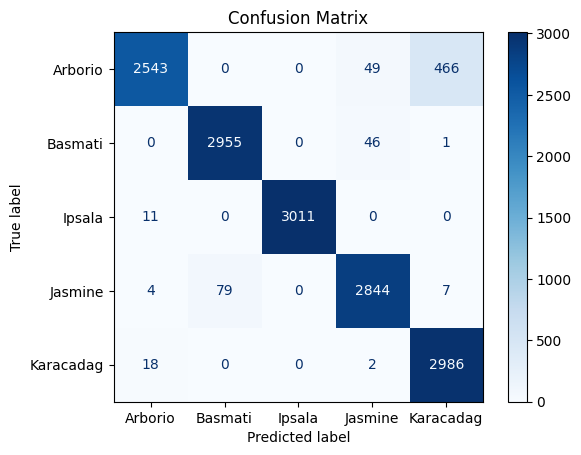

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_preds = []
all_labels = []
for images, labels in test_loader:
  images, labels = images.to(DEVICE), labels.to(DEVICE)
  outputs = final_model(images)
  _, preds = torch.max(outputs, 1)
  all_preds.extend(preds.cpu().numpy())
  all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=FULL_DATASET.classes)

# Plot confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [19]:
best = {'lr': 0.001, 'hidden_size': 32, 'weight_decay': 1e-5}
best_hidden = best['hidden_size']

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import torch
import numpy as np
y_pred = []
y_true = []
final_model.eval()
print("Generating predictions...")
with torch.no_grad():
    for images, labels in test_loader:

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        outputs = final_model(images)

        _, predicted = torch.max(outputs, 1)

        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())
print("Predictions generated successfully.")
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred, target_names=FULL_DATASET.classes))

Generating predictions...


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

The "Basmati vs. Jasmine" Confusion is Quantified
Basmati Recall (0.80): This is our lowest score. It means 20% of real Basmati rice is being missed. Based on our Confusion Matrix, we know they are being mislabeled as Jasmine.

Jasmine Precision (0.77): This is also low. It means that when our model claims "This is Jasmine," it is only right 77% of the time. Why? Because it's "hallucinating" Jasmine when it actually sees Basmati.


While the model achieved an overall accuracy of 92%, performance was non-uniform across classes. Specifically, the model struggled to distinguish Basmati from Jasmine, resulting in a lower recall for Basmati (0.80) and lower precision for Jasmine (0.77). This suggests the model relies heavily on features (likely grain length or color) that are shared between these two specific rice varieties.

Ipsala is the "Control Group"
Ipsala (Precision 1.00, Recall 0.96): The model is basically perfect at identifying Ipsala.

This proves our model architecture works well. The failure on Basmati isn't because our CNN is broken; it's because the data (the images of those specific grains) is harder to distinguish.

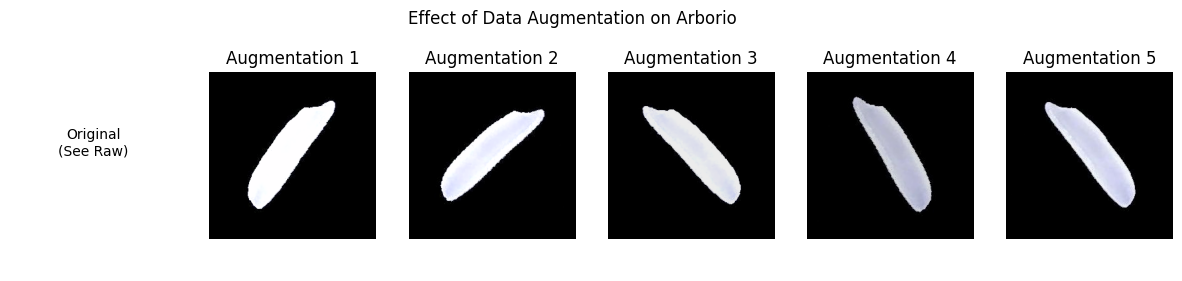

In [21]:
# Visualize Data Augmentation Effects
def visualize_augmentation(dataset, idx=0):
    raw_img, label = dataset[idx] #

    fig, axes = plt.subplots(1, 6, figsize=(15, 3))

    axes[0].text(0.5, 0.5, "Original\n(See Raw)", ha='center')
    axes[0].axis('off')

    for i in range(1, 6):
        img_aug, _ = train_set[idx]

        img_display = img_aug.clone()
        mean = [0.1179, 0.1189, 0.1229]
        std = [0.2851, 0.2875, 0.2989]
        for c in range(3):
            img_display[c] = img_display[c] * std[c] + mean[c]

        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)

        axes[i].imshow(img_display)
        axes[i].set_title(f"Augmentation {i}")
        axes[i].axis('off')

    plt.suptitle(f"Effect of Data Augmentation on {FULL_DATASET.classes[label]}")
    plt.show()

visualize_augmentation(FULL_DATASET, idx=100)

Scanning for Basmati -> Jasmine errors... (This might take a moment)
Found 5 misclassified examples.


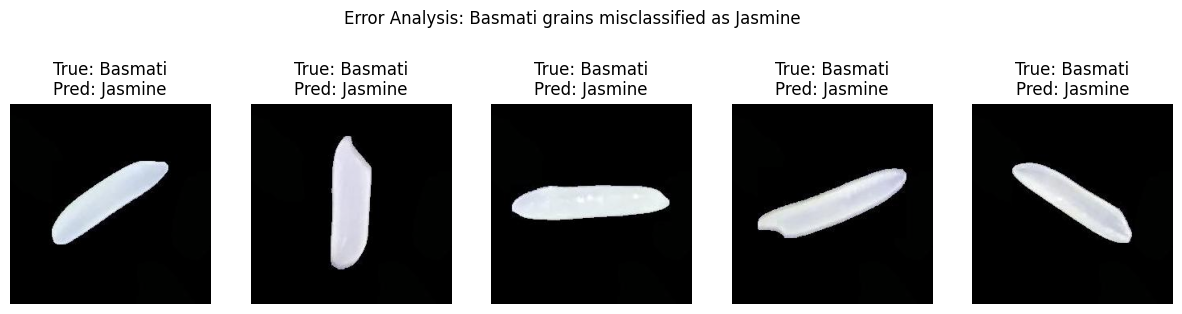

In [26]:
test_transform = transforms.Compose([
    transforms.Resize((250,250)),
    transforms.ToTensor(),

    transforms.Normalize(mean=[0.1179, 0.1189, 0.1229], std=[0.2851, 0.2875, 0.2989])
])
basmati_idx = FULL_DATASET.class_to_idx['Basmati']
jasmine_idx = FULL_DATASET.class_to_idx['Jasmine']

print("Scanning for Basmati -> Jasmine errors... (This might take a moment)")
found_images = []
final_model.eval()

with torch.no_grad():
    for i in range(len(FULL_DATASET)):
        if len(found_images) >= 5: break


        path, label = FULL_DATASET.samples[i]

        if label == basmati_idx:
            img_tensor, _ = FULL_DATASET[i]

            img_raw = FULL_DATASET.loader(path) # Load raw PIL
            img_input = test_transform(img_raw).unsqueeze(0).to(DEVICE)

            output = final_model(img_input)
            _, pred = torch.max(output, 1)

            if pred.item() == jasmine_idx:
                found_images.append(img_input.cpu().squeeze(0))

print(f"Found {len(found_images)} misclassified examples.")

if len(found_images) > 0:
    plt.figure(figsize=(15, 4))
    for i, img_tensor in enumerate(found_images):
        ax = plt.subplot(1, 5, i+1)

        # Un-normalize
        img_display = img_tensor.clone()
        mean = [0.1179, 0.1189, 0.1229]
        std = [0.2851, 0.2875, 0.2989]
        for c in range(3):
            img_display[c] = img_display[c] * std[c] + mean[c]

        img_display = img_display.permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)

        ax.imshow(img_display)
        ax.set_title("True: Basmati\nPred: Jasmine")
        ax.axis('off')

    plt.suptitle("Error Analysis: Basmati grains misclassified as Jasmine")
    plt.show()
else:
    print("No errors found in the scanned samples")

Extracting CNN features...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


K-Means Adjusted Rand Index (clustering quality): 0.6092


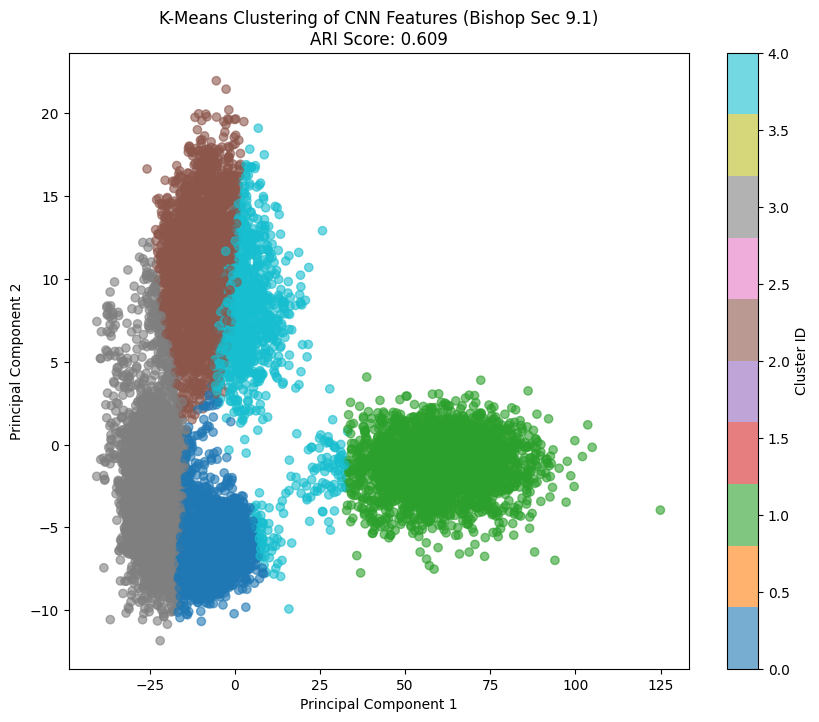

In [27]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

feature_list = []
label_list = []

final_model.eval()
print("Extracting CNN features...")
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)

        # Pass through the convolutional layers
        x = final_model.features(images)
        x = final_model.classifier[0](x) # AdaptiveAvgPool
        x = final_model.classifier[1](x) # Flatten

        feature_list.extend(x.cpu().numpy())
        label_list.extend(labels.numpy())

features = np.array(feature_list)
labels = np.array(label_list)

kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(features)

ari = adjusted_rand_score(labels, clusters)
print(f"K-Means Adjusted Rand Index (clustering quality): {ari:.4f}")

pca_features = PCA(n_components=2).fit_transform(features)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='tab10', alpha=0.6)
plt.title(f'K-Means Clustering of CNN Features (Bishop Sec 9.1)\nARI Score: {ari:.3f}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster ID')
plt.show()